# Partie 3: application à la classification de fonds marins


Dans la suite, vous êtes chargé :
- d'appliquer la démarche décrite dans la partie 2 aux données des images sonar de fonds marins rencontrés précédemment. 
- Analyser proprement les performances
- Modifier l'architecture de réseau pour améliorer les performances

Si vous ne savez pas commencer, le script ci-dessous pourra certainement vous aider à démarrer.


In [201]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import tensorflow as tf

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    DATASET_PATH = 'gdrive/My Drive/Colab Notebooks/ex06_supervised_seabedClassification/dataset/imgs/'
    LABEL_PATH = 'gdrive/My Drive/Colab Notebooks/ex06_supervised_seabedClassification/dataset/labels/labels.csv'
else:
    IN_COLAB = False
    DATASET_PATH = r'./dataset/imgs/'
    LABEL_PATH = r'./dataset/labels/labels.csv'

# Charger le fichier CSV
dataset_df = pd.read_csv(LABEL_PATH)
dataset_df['image_path'] = dataset_df.apply(lambda row: (DATASET_PATH + row["id"]), axis=1)


# Charger les images et les labels
images = np.array([plt.imread(img) for img in dataset_df['image_path'].values.tolist()])
label_names = dataset_df['seafloor'].to_numpy()

# transformer les labels en indices
label_names = dataset_df['seafloor']

label_names_unique = label_names.unique()
le = preprocessing.LabelEncoder()
le.fit(label_names_unique)
label_indices = le.transform(label_names)

# ohe
lohe = preprocessing.OneHotEncoder()
lohe.fit(label_names_unique.reshape(label_names_unique.size, 1))
label_ohe = lohe.transform(np.array(label_names).reshape(label_names.size, 1))

# rajout d'une dimension chanel pour coller au formalisme de tensorflow
images = images[...,np.newaxis]


# Création du dataset en objet tf.data.Dataset
tf_dataset = tf.data.Dataset.from_tensor_slices((images, label_indices))

In [202]:
split = 3
ds_train = tf_dataset.window(split, split + 1).flat_map(lambda *ds: ds[0] if len(ds) == 1 else tf.data.Dataset.zip(ds))
ds_test = tf_dataset.skip(split).window(1, split + 1).flat_map(lambda *ds: ds[0] if len(ds) == 1 else tf.data.Dataset.zip(ds))

ds_train = ds_train.batch(batch_size, drop_remainder=True)
ds_test = ds_test.batch(batch_size, drop_remainder=True)

In [204]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(normalize_img)
ds_test  = ds_test.map(normalize_img)

In [205]:
img_shape = images[0].shape
input_img_size = images[0].size
num_classes = np.count_nonzero(le.classes_)
batch_size = 30

In [226]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(img_shape)),
    tf.keras.layers.Dense(12, activation="softmax"),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

In [227]:
# performance du modèle
def eval_loop():
    # evaluating the model
    cor_pred = []
    accuracy_tot = []
    for i_batch, (img, target_label) in enumerate(ds_train):
        #img = tf.reshape(img, [batch_size, input_img_size, 1])
        target_pred = model.predict(img)
        target_pred = tf.argmax(target_pred, axis=1)

        # performance measures
        correct_prediction = tf.equal(target_pred, target_label)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        cor_pred.append(correct_prediction)
        accuracy_tot.append(accuracy.numpy())
    return np.mean(accuracy_tot)

print(eval_loop())

0.1875


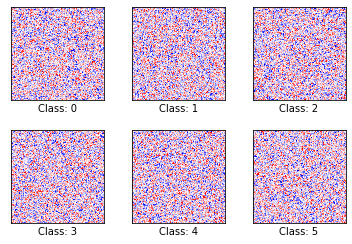

In [228]:
def plot_weights(weights, img_shape):
        w_min = np.min(weights)
        w_max = np.max(weights)

        fig, axes = plt.subplots(2, 3)
        fig.subplots_adjust(hspace=0.3, wspace=0.3)

        for i, ax in enumerate(axes.flat):
            image = weights[:, i].reshape(img_shape)
            ax.set_xlabel("Class: {0}".format(i))
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
        plt.show()

# Get the values for the weights from the TensorFlow variable.
weights = model.get_weights()
weights = weights[0]

# visualisation des poids
plot_weights(weights, img_shape[0:2])

In [229]:
loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss(model, x, y, training):
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    y_ = model(x, training=training)

    return loss_fcn(y_true=y, y_pred=y_)

l = loss(model, images, label_indices, training=False)
print("Loss test: {}".format(l))


 # Utilisez le contexte tf.GradientTape pour calculer les gradients utilisés pour optimiser votre modèle:

def grad(model, inputs, targets):
    
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

Loss test: 1.791865348815918


In [230]:
optimizer_fcn = tf.keras.optimizers.SGD(learning_rate=1.0)

def optimize(features, target_labels):

    # Compute the loss and the gradient
    loss_value, grads = grad(model, features, target_labels)

    # mise à jour des paramètres
    optimizer_fcn.apply_gradients(zip(grads, model.trainable_variables))

    # return gradients

In [231]:
def train_loop(num_epochs):
    for epoch in range(0, num_epochs, 1):

        # Get a batch of training examples.
        # img_batch now holds a batch of images and
        # label_batch are the true labels for those images.
        (img_batch, label_batch) = next(iter(ds_train))

        # optimize
        optimize(img_batch, label_batch)

        print("Step: {},         Loss: {}".format(optimizer_fcn.iterations.numpy(), loss(model, img_batch, label_batch, training=True).numpy()))

In [232]:
model.compile(
              loss=loss_fcn, 
              optimizer=optimizer_fcn, 
              metrics=[tf.keras.metrics.sparse_categorical_accuracy]
             )

In [233]:
num_epochs = 100
history = model.fit(ds_train, epochs=num_epochs, validation_data=ds_test)

Epoch 1/100
4/4 [==============================] - 0s 82ms/step - loss: 1.7975 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 1.7897 - val_sparse_categorical_accuracy: 0.2500
Epoch 2/100
4/4 [==============================] - 0s 57ms/step - loss: 1.7963 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 1.7877 - val_sparse_categorical_accuracy: 0.2500
Epoch 3/100
4/4 [==============================] - 0s 61ms/step - loss: 1.7952 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 1.7860 - val_sparse_categorical_accuracy: 0.2500
Epoch 4/100
4/4 [==============================] - 0s 66ms/step - loss: 1.7943 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 1.7845 - val_sparse_categorical_accuracy: 0.2500
Epoch 5/100
4/4 [==============================] - 0s 58ms/step - loss: 1.7935 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 1.7831 - val_sparse_categorical_accuracy: 0.2500
Epoch 6/100
4/4 [==============================] - 0s 55ms/step - loss: 1.7928 - sparse_ca

In [234]:
target_pred = model.predict(ds_train)
target_label_pred = tf.argmax(target_pred, axis=1).numpy()
print(target_label_pred.shape)

(240,)


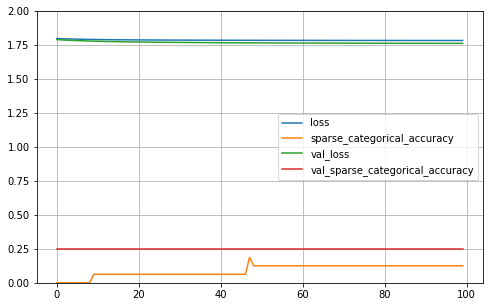

4/4 [==============================] - 0s 14ms/step - loss: 1.7756 - sparse_categorical_accuracy: 0.1875
{'loss': 1.7755872011184692, 'sparse_categorical_accuracy': 0.1875}


0.1875

In [235]:
# learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)  # set the vertical range to [0-1]
plt.show()

# métriques de performance:

result = model.evaluate(ds_train)
print(dict(zip(model.metrics_names, result)))

eval_loop()

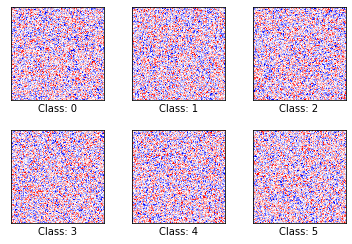

In [236]:
# Visualize the weights of the model
weights = model.get_weights()
weights = weights[0]
plot_weights(weights, img_shape[0:2])